## import libraries

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'
    
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time
import scipy.io as sio
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
#from torchvision.datasets import CELEBA

num GPUs 1


## load generator pre-trained mnist network

In [2]:
#G
from dcgan import Generator

G = Generator(ngpu=1).eval()

# load weights
G.load_state_dict(torch.load('netG_epoch_99.pth'))
if torch.cuda.is_available():
    G = G.cuda()

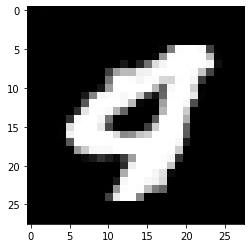

In [3]:
batch_size = 1
latent_size = 100
z_true = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=False)
x_true = G(z_true).cpu().detach().numpy().squeeze()
plt.imshow(x_true,cmap="gray")

In [4]:
mc = 500
#generate samples z
batch_size = mc
latent_size = 100
z = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=True)

In [5]:
def dfdz(G,z):
    f = G(z).view(-1)
    k = z.view(-1).size()[0]
    d = f.size()[0]
    gradlist = torch.zeros([d,k],dtype=torch.float)
    for i in range(d):
        ff = f[i]
        ff.backward(retain_graph=True)
        gradlist[i,:] = z.grad.squeeze()
        z.grad = torch.zeros_like(z.grad)
    return gradlist # 784 \times 100    

In [6]:
def dfdz2(G,z):
    k = z.view(-1).size()[0]
    f = G(z).view(-1)
    
    d = f.size()[0]
    gradlist = torch.zeros([d,k],dtype=torch.float)
    for i in range(d):
        f = G(z).view(-1)
        ff = f[i]
        ff.backward()#(retain_graph=True)
        gradlist[i,:] = z.grad.squeeze()
        z.grad = torch.zeros_like(z.grad)
    return gradlist # 784 \times 100    

In [7]:
y1 = []
y2 = []
latent_size = 100
for j in range(mc):
    z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
    dfmat = dfdz(G,z_j).to('cuda')
    inp1 = torch.matmul(dfmat.T,(G(z_j).view(-1)-G(z_true).view(-1)))
    inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_true.squeeze())
    y1.append(inp2.detach().cpu().numpy())
    normzdiff = torch.norm(z_j-z_true)**2
    y2.append(normzdiff.detach().cpu().numpy())

In [8]:
yy = []
xx = []
beta = 800
alpha = 2
for i in range(mc):
    yy.append(y1[i])
    xx.append(alpha*y2[i]- beta) 

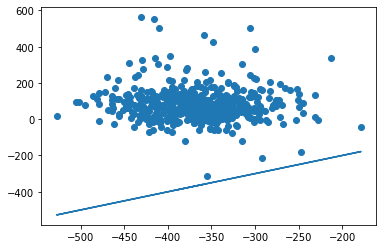

In [9]:
plt.scatter(xx,yy)
plt.plot(xx,xx)

In [ ]:
y3 = []
y4 = []
latent_size = 100
for j in range(mc):
    z_t = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=False)
    z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
    dfmat = dfdz(G,z_j).to('cuda')
    inp1 = torch.matmul(dfmat.T,(G(z_j).view(-1)-G(z_t).view(-1)))
    inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_true.squeeze())
    y3.append(inp2.detach().cpu().numpy())
    normzdiff = torch.norm(z_j-z_true)**2
    y4.append(normzdiff.detach().cpu().numpy())

In [ ]:
yy = []
xx = []
beta = 1000
alpha = 5
for i in range(mc):
    yy.append(y3[i])
    xx.append(alpha*y4[i]- beta) 

In [ ]:
plt.scatter(xx,yy)
plt.plot(xx,xx)

# load generator pre-trained network for cifar

In [13]:
#G
from dcgan_cifar import Generator

G = Generator(ngpu=1).eval()

# load weights
G.load_state_dict(torch.load('netG_epoch_199_cifar.pth'))
if torch.cuda.is_available():
    G = G.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


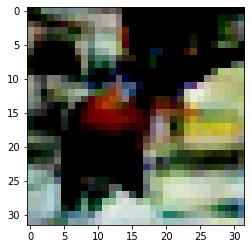

In [14]:
batch_size = 1
latent_size = 100
z_true = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=False)
x_true = G(z_true).cpu().detach().numpy().squeeze()
plt.imshow(x_true.transpose(1, 2, 0))

In [15]:
mc = 500
#generate samples z
batch_size = mc
latent_size = 100
z = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=True)

In [16]:
cy1 = []
cy2 = []
latent_size = 100
for j in range(mc):
    z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
    dfmat = dfdz(G,z_j).to('cuda')
    inp1 = torch.matmul(dfmat.T,(G(z_j).view(-1)-G(z_true).view(-1)))
    inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_true.squeeze())
    cy1.append(inp2.detach().cpu().numpy())
    normzdiff = torch.norm(z_j-z_true)**2
    cy2.append(normzdiff.detach().cpu().numpy())

In [17]:
cyy = []
cxx = []
beta = 600
alpha = 2
for i in range(mc):
    cyy.append(cy1[i])
    cxx.append(alpha*cy2[i]- beta) 

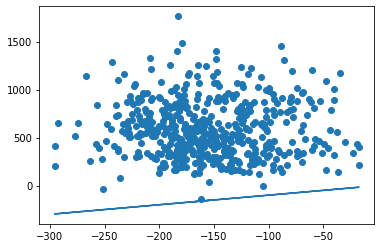

In [18]:
plt.scatter(cxx,cyy)
plt.plot(cxx,cxx)

In [ ]:
cy3 = []
cy4 = []
latent_size = 100
for j in range(mc):
    z_t = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=False)
    z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
    dfmat = dfdz(G,z_j).to('cuda')
    inp1 = torch.matmul(dfmat.T,(G(z_j).view(-1)-G(z_t).view(-1)))
    inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_true.squeeze())
    cy3.append(inp2.detach().cpu().numpy())
    normzdiff = torch.norm(z_j-z_true)**2
    cy4.append(normzdiff.detach().cpu().numpy())

In [ ]:
cyy = []
cxx = []
beta = 600
alpha = 2
for i in range(mc):
    cyy.append(cy3[i])
    cxx.append(alpha*cy4[i]- beta) 

In [ ]:
plt.scatter(cxx,cyy)
plt.plot(cxx,cxx)

In [ ]:
plotvals = [y1,y2,y3,y4,cy1,cy2,cy3,cy4]
np.save('plotvals_500.npy',plotvals)